In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.metrics import mean_squared_error
import math

In [2]:
# 1. Download Apple stock data (only Close)
df = yf.download("AAPL", start="1980-01-01") 
df1 = df[['Close']]   # keep only Close column

C:\Users\Huzaifa\AppData\Local\Temp\ipykernel_11516\1948976611.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="1980-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
# 2. Scale Close price
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df1)

In [4]:
# 3. Train-test split
train_size = int(len(data) * 0.65)
train_data = data[:train_size]
test_data  = data[train_size:]

In [5]:
# 4. Create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        X = dataset[i:(i+time_step), 0]
        Y = dataset[i + time_step, 0]
        dataX.append(X)
        dataY.append(Y)
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test,  ytest   = create_dataset(test_data, time_step)

In [6]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0],  X_test.shape[1],  1)

In [7]:
# 5. Build model
model = Sequential()
model.add(Input(shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 6. Train model (10 epochs)
model.fit(X_train, y_train, validation_data=(X_test,ytest),
          epochs=10, batch_size=64, verbose=1)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 417ms/step - loss: 1.9412e-05 - val_loss: 0.0121
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 75s 357ms/step - loss: 3.9728e-07 - val_loss: 0.0113
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - loss: 4.4535e-07 - val_loss: 0.0104
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - loss: 3.7651e-07 - val_loss: 0.0068
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - loss: 4.1659e-07 - val_loss: 0.0068
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - loss: 4.0247e-07 - val_loss: 0.0066
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - loss: 4.3622e-07 - val_loss: 0.0038
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 257ms/step - loss: 3.1999e-07 - val_loss: 0.0061
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - loss: 2.6175e-07 - val_loss: 0.0039
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - loss: 2.8329e-07 - val_loss: 0.0053


In [9]:
# 7. Predictions
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


In [10]:
# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)
y_train_inv   = scaler.inverse_transform(y_train.reshape(-1,1))
ytest_inv     = scaler.inverse_transform(ytest.reshape(-1,1))

In [11]:
# 8. RMSE
print("Train RMSE:", math.sqrt(mean_squared_error(y_train_inv, train_predict)))
print("Test RMSE:",  math.sqrt(mean_squared_error(ytest_inv, test_predict)))

Train RMSE: 0.15255588057079297
Test RMSE: 18.829850762654598


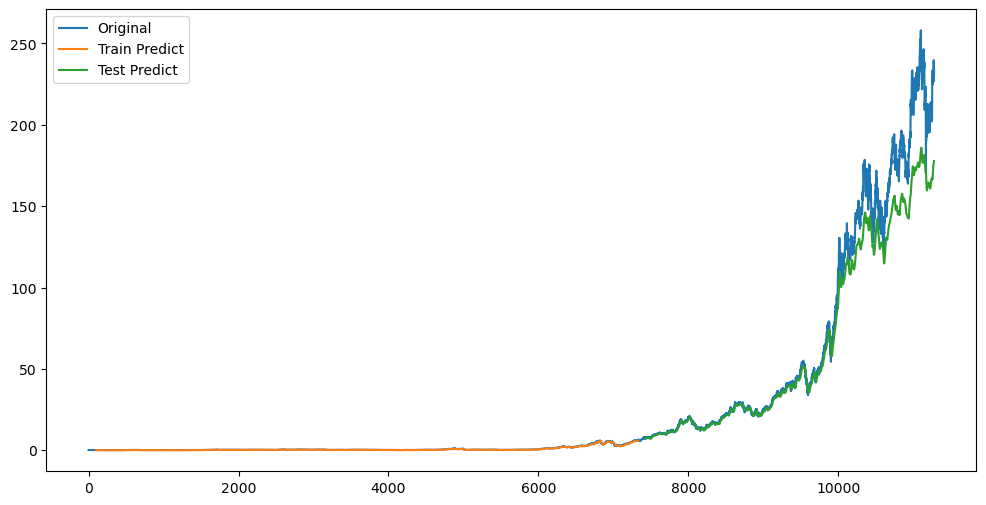

In [15]:
# 9. Plot predictions
look_back = 100

# Train predictions plot
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Test predictions plot (fixed indexing)
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan

start = len(train_predict) + (look_back*2) + 1
end = len(data)
testPredictPlot[start:end, :] = test_predict[:end-start]

# Plot everything
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(data), label="Original")
plt.plot(trainPredictPlot, label="Train Predict")
plt.plot(testPredictPlot, label="Test Predict")
plt.legend()
plt.show()


In [16]:
# 10. Forecast next 30 days
temp_input = test_data[-100:].reshape(1,-1).tolist()[0]
lst_output = []
n_steps = 100

for i in range(30):
    x_input = np.array(temp_input[-100:]).reshape(1, n_steps, 1)
    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    lst_output.append(yhat[0][0])


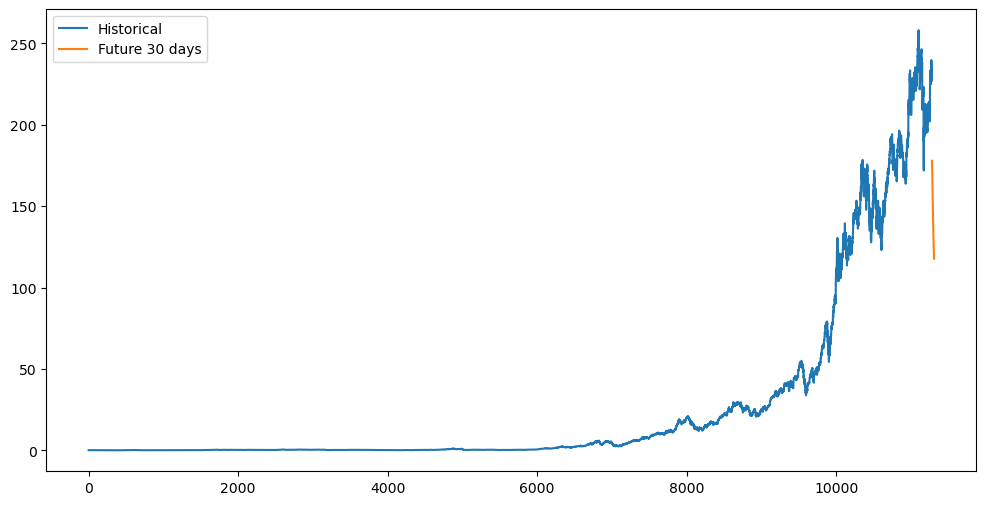

In [18]:
# Convert back to original scale
future_pred = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

# 11. Plot future forecast
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(data), label="Historical")
plt.plot(range(len(data), len(data)+30), future_pred, label="Future 30 days")
plt.legend()
plt.show()